## Bart vs Homer: Image Classification

Dataset Source: https://www.kaggle.com/datasets/williamu32/dataset-bart-or-homer

##### Install Necessary Libraries Not Already Installed

In [1]:
%pip install datasets transformers

Note: you may need to restart the kernel to use updated packages.


##### Import Necessary Libraries

In [2]:
import os, sys, random
os.environ['TOKENIZERS_PARALLELISM']='false'

from PIL import ImageDraw, ImageFont, Image
import PIL.Image

from tqdm import tqdm

import numpy as np
import pandas as pd

import datasets
from datasets import load_dataset, Image, load_metric, concatenate_datasets

import transformers
from transformers import Trainer, TrainingArguments
from transformers import ViTForImageClassification, ViTFeatureExtractor

import torch

NOTE: Redirects are currently not supported in Windows or MacOs.


##### Display Versions of Relevant Libraries

In [3]:
print("Python:".rjust(15), sys.version[0:6])
print("NumPy:".rjust(15), np.__version__)
print("Pandas:".rjust(15), pd.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Torch:".rjust(15), torch.__version__)

        Python: 3.9.12
         NumPy: 1.22.4
        Pandas: 1.4.4
      Datasets: 2.4.0
  Transformers: 4.25.1
         Torch: 1.12.1


##### Ingest Dataset

In [4]:
dataset = load_dataset("imagefolder", 
                        data_dir="/Users/briandunn/Documents/nlpnn/Datasets/Bart & Homer/", 
                        drop_labels=False)

print(dataset['train'])
print(dataset['train'][0])

Resolving data files:   0%|          | 0/196 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/73 [00:00<?, ?it/s]

Using custom data configuration default-3ac6e25ca7735972
Reusing dataset imagefolder (/Users/briandunn/.cache/huggingface/datasets/imagefolder/default-3ac6e25ca7735972/0.0.0/0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff)


  0%|          | 0/2 [00:00<?, ?it/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 196
})
{'image': <PIL.BmpImagePlugin.BmpImageFile image mode=RGB size=364x435 at 0x7F8B7990A220>, 'label': 0}


##### Display Grid of Examples From Each Class to Gain Better Picture of Data

In [5]:
def show_grid_of_examples(ds, 
                          seed: int = 42, 
                          examples_per_class: int = 3, 
                          size=(350, 350)):
    '''
    This function displays a few pictures
    from each class in the dataset.
    '''
    w, h = size
    labels = ds['train'].features['label'].names
    grid = PIL.Image.new(mode='RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("Chalkduster.ttf", 24)
    
    for label_id, label in enumerate(labels):
        # filter the dataset by a single label, shuffle it, then grab a few samples
        ds_slice = ds['train'] \
                    .filter(lambda ex: ex['label'] == label_id) \
                    .shuffle(seed) \
                    .select(range(examples_per_class))
        
        # plot this label's examples in a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (0, 0, 255), font=font)    
    return grid

Loading cached processed dataset at /Users/briandunn/.cache/huggingface/datasets/imagefolder/default-3ac6e25ca7735972/0.0.0/0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff/cache-f0f34f80a90fa8e0.arrow
Loading cached shuffled indices for dataset at /Users/briandunn/.cache/huggingface/datasets/imagefolder/default-3ac6e25ca7735972/0.0.0/0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff/cache-1cb812ec9417fe69.arrow
Loading cached processed dataset at /Users/briandunn/.cache/huggingface/datasets/imagefolder/default-3ac6e25ca7735972/0.0.0/0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff/cache-75caae692d4205c6.arrow
Loading cached shuffled indices for dataset at /Users/briandunn/.cache/huggingface/datasets/imagefolder/default-3ac6e25ca7735972/0.0.0/0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff/cache-d07d285c17a2d3f5.arrow


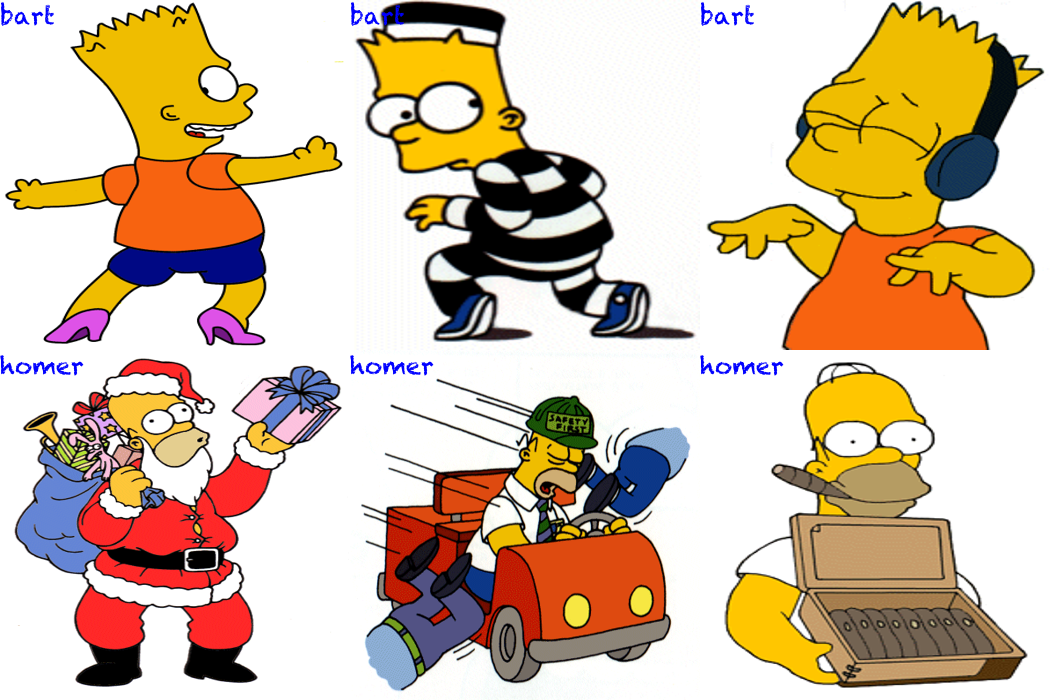

In [6]:
show_grid_of_examples(dataset, seed=42, examples_per_class=3)

##### Remember to Install git lfs & Enter HuggingFace Access Token

In [7]:
# Enter Huggingface Access Token

!git lfs install

Git LFS initialized.


##### Basic Values/Constants

In [8]:
MODEL_CKPT='google/vit-base-patch16-224-in21k'
NUM_OF_EPOCHS=3

LEARNING_RATE=2e-4
STEPS=100

BATCH_SIZE=16
DEVICE = torch.device("mps")

REPORTS_TO='tensorboard'

##### Load ViT Feature Extractor

In [9]:
feature_extractor = ViTFeatureExtractor.from_pretrained(MODEL_CKPT)

##### Preprocessing Dataset

In [10]:
def transform(sample_batch):
    # Convert list of PIL images into pixel values
    inputs = feature_extractor([x for x in sample_batch['image']], return_tensors="pt")
    
    # prep labels
    inputs['labels'] = sample_batch['label']
    return inputs

##### Apply Transform Function to Dataset

In [11]:
prepped_ds = dataset.with_transform(transform)

#### Training & Evaluation

##### Define Data Collator

In [12]:
def data_collator(batch):
    return {
        'pixel_values' : torch.stack([x['pixel_values'] for x in batch]),
        'labels' : torch.tensor([x['labels'] for x in batch])
    }

##### Define Evaluation Metric

In [13]:
def compute_metrics(p):
    accuracy_metric = load_metric("accuracy")
    accuracy = accuracy_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)["accuracy"]
    
    f1_score_metric = load_metric("f1")
    f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)["f1"]
    
    recall_metric = load_metric("recall")
    recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)["recall"]
    
    precision_metric = load_metric("precision")
    precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)["precision"]
    
    return {"accuracy" : accuracy, 
            "f1" : f1_score,
            "recall" : recall,
            "precision" : precision}
    

##### Load Pretrained Model

In [14]:
labels = dataset['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(
    MODEL_CKPT,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
).to(DEVICE)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##### Define Training Arguments

In [15]:
args = TrainingArguments(
    output_dir=MODEL_CKPT + "_Bart_or_Homer",
    remove_unused_columns=False,
    num_train_epochs=NUM_OF_EPOCHS,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    report_to=REPORTS_TO,
    disable_tqdm=False,
    load_best_model_at_end=True,
    logging_first_step=True,
    push_to_hub=True
)

##### Instantiate Trainer

In [16]:
trainer = Trainer(
    model = model,
    args= args,
    data_collator = data_collator,
    compute_metrics = compute_metrics,
    train_dataset=prepped_ds['train'],
    eval_dataset=prepped_ds['test'],
    tokenizer=feature_extractor,
)

/Users/briandunn/Documents/nlpnn/google/vit-base-patch16-224-in21k_Bart_or_Homer is already a clone of https://huggingface.co/DunnBC22/vit-base-patch16-224-in21k_Bart_or_Homer. Make sure you pull the latest changes with `repo.git_pull()`.


##### Train Model

In [17]:
train_results = trainer.train()

/Users/briandunn/Documents/nlpnn/nlp_projects/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 196
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 39
  Number of trainable parameters = 85800194


  0%|          | 0/39 [00:00<?, ?it/s]

{'loss': 0.6996, 'learning_rate': 0.00019487179487179487, 'epoch': 0.08}


***** Running Evaluation *****
  Num examples = 73
  Batch size = 8


  0%|          | 0/10 [00:00<?, ?it/s]

Saving model checkpoint to google/vit-base-patch16-224-in21k_Bart_or_Homer/checkpoint-13
Configuration saved in google/vit-base-patch16-224-in21k_Bart_or_Homer/checkpoint-13/config.json
Model weights saved in google/vit-base-patch16-224-in21k_Bart_or_Homer/checkpoint-13/pytorch_model.bin
Image processor saved in google/vit-base-patch16-224-in21k_Bart_or_Homer/checkpoint-13/preprocessor_config.json


{'eval_loss': 0.1327018141746521, 'eval_accuracy': 0.9726027397260274, 'eval_f1': 0.96875, 'eval_recall': 1.0, 'eval_precision': 0.9393939393939394, 'eval_runtime': 68.9476, 'eval_samples_per_second': 1.059, 'eval_steps_per_second': 0.145, 'epoch': 1.0}


Image processor saved in google/vit-base-patch16-224-in21k_Bart_or_Homer/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8


  0%|          | 0/10 [00:00<?, ?it/s]

Saving model checkpoint to google/vit-base-patch16-224-in21k_Bart_or_Homer/checkpoint-26
Configuration saved in google/vit-base-patch16-224-in21k_Bart_or_Homer/checkpoint-26/config.json


{'eval_loss': 0.06357364356517792, 'eval_accuracy': 0.9863013698630136, 'eval_f1': 0.9841269841269841, 'eval_recall': 1.0, 'eval_precision': 0.96875, 'eval_runtime': 70.4809, 'eval_samples_per_second': 1.036, 'eval_steps_per_second': 0.142, 'epoch': 2.0}


Model weights saved in google/vit-base-patch16-224-in21k_Bart_or_Homer/checkpoint-26/pytorch_model.bin
Image processor saved in google/vit-base-patch16-224-in21k_Bart_or_Homer/checkpoint-26/preprocessor_config.json
Image processor saved in google/vit-base-patch16-224-in21k_Bart_or_Homer/preprocessor_config.json
Adding files tracked by Git LFS: ['.DS_Store']. This may take a bit of time if the files are large.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8


  0%|          | 0/10 [00:00<?, ?it/s]

Saving model checkpoint to google/vit-base-patch16-224-in21k_Bart_or_Homer/checkpoint-39
Configuration saved in google/vit-base-patch16-224-in21k_Bart_or_Homer/checkpoint-39/config.json
Model weights saved in google/vit-base-patch16-224-in21k_Bart_or_Homer/checkpoint-39/pytorch_model.bin
Image processor saved in google/vit-base-patch16-224-in21k_Bart_or_Homer/checkpoint-39/preprocessor_config.json


{'eval_loss': 0.14195850491523743, 'eval_accuracy': 0.9452054794520548, 'eval_f1': 0.9393939393939393, 'eval_recall': 1.0, 'eval_precision': 0.8857142857142857, 'eval_runtime': 65.6028, 'eval_samples_per_second': 1.113, 'eval_steps_per_second': 0.152, 'epoch': 3.0}


Image processor saved in google/vit-base-patch16-224-in21k_Bart_or_Homer/preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from google/vit-base-patch16-224-in21k_Bart_or_Homer/checkpoint-26 (score: 0.06357364356517792).


{'train_runtime': 1782.8603, 'train_samples_per_second': 0.33, 'train_steps_per_second': 0.022, 'train_loss': 0.16014800927577874, 'epoch': 3.0}


In [18]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Saving model checkpoint to google/vit-base-patch16-224-in21k_Bart_or_Homer
Configuration saved in google/vit-base-patch16-224-in21k_Bart_or_Homer/config.json
Model weights saved in google/vit-base-patch16-224-in21k_Bart_or_Homer/pytorch_model.bin
Image processor saved in google/vit-base-patch16-224-in21k_Bart_or_Homer/preprocessor_config.json
Saving model checkpoint to google/vit-base-patch16-224-in21k_Bart_or_Homer
Configuration saved in google/vit-base-patch16-224-in21k_Bart_or_Homer/config.json
Model weights saved in google/vit-base-patch16-224-in21k_Bart_or_Homer/pytorch_model.bin
Image processor saved in google/vit-base-patch16-224-in21k_Bart_or_Homer/preprocessor_config.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 32.0k/327M [00:00<?, ?B/s]

Upload file runs/Jan04_17-43-26_Brians-Mac-mini/events.out.tfevents.1672875809.Brians-Mac-mini.12464.0: 100%|#…

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/vit-base-patch16-224-in21k_Bart_or_Homer
   85f9392..86c7a8c  main -> main

To https://huggingface.co/DunnBC22/vit-base-patch16-224-in21k_Bart_or_Homer
   86c7a8c..ed23e60  main -> main



***** train metrics *****
  epoch                    =        3.0
  train_loss               =     0.1601
  train_runtime            = 0:29:42.86
  train_samples_per_second =       0.33
  train_steps_per_second   =      0.022


##### Evaluate Model

In [19]:
metrics = trainer.evaluate(prepped_ds['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 73
  Batch size = 8


  0%|          | 0/10 [00:00<?, ?it/s]

***** eval metrics *****
  epoch                   =        3.0
  eval_accuracy           =     0.9863
  eval_f1                 =     0.9841
  eval_loss               =     0.0636
  eval_precision          =     0.9688
  eval_recall             =        1.0
  eval_runtime            = 0:01:05.70
  eval_samples_per_second =      1.111
  eval_steps_per_second   =      0.152


##### Push Model to Hub (My Profile!)

In [20]:
kwargs = {
    "finetuned_from" : model.config._name_or_path,
    "tasks" : "image-classification",
    "tags" : ["image-classification"],
}

if args.push_to_hub:
    trainer.push_to_hub("All Dunn!!!")
else:
    trainer.create_model_card(**kwargs)

Saving model checkpoint to google/vit-base-patch16-224-in21k_Bart_or_Homer
Configuration saved in google/vit-base-patch16-224-in21k_Bart_or_Homer/config.json
Model weights saved in google/vit-base-patch16-224-in21k_Bart_or_Homer/pytorch_model.bin
Image processor saved in google/vit-base-patch16-224-in21k_Bart_or_Homer/preprocessor_config.json


Upload file runs/Jan04_17-43-26_Brians-Mac-mini/events.out.tfevents.1672878158.Brians-Mac-mini.12464.2: 100%|#…

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/vit-base-patch16-224-in21k_Bart_or_Homer
   ed23e60..1928674  main -> main

To https://huggingface.co/DunnBC22/vit-base-patch16-224-in21k_Bart_or_Homer
   1928674..6203694  main -> main



### Notes & Other Takeaways
****
- I am pleased with the results. While this dataset has a smaller dataset, it did allow me to work through some of the technical details and improve my understanding of how the ViT-related transformers operate.
****
- Now, it is time to work on projects with larger sample sizes.
****